In [1]:
%pip install pandas
%pip install scipy
import matplotlib.pyplot as plt
import numpy as np
import yt
import matplotlib.cm as cm
#from plot_variables import *
from yt.utilities.math_utils import ortho_find
from helper_functions import *
from helper_functions import _h2_fraction

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from yt.data_objects.level_sets.api import * # for clump finding

### Load dataset and find ss properties

In [3]:
ds = yt.load("/disk14/sgordon/pleiades-11-12-23/seed1-bh-only/270msun/replicating-beckmann/1B.RSb01-2/DD0445/DD0445")
#ds.add_field(("gas", "h2_fraction"), function=_h2_fraction, units="dimensionless", display_name="H2 Fraction", sampling_type="cell")

ss_pos, ss_mass, ss_age = ss_properties(ds, velocity=False)
print("position = {}, mass = {:.2f}, age = {:.2f} Myr".format(ss_pos, ss_mass, ss_age[0]/1e6))

yt : [INFO     ] 2024-03-27 09:56:08,240 Parameters: current_time              = 17.475156649306
yt : [INFO     ] 2024-03-27 09:56:08,241 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-03-27 09:56:08,242 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-03-27 09:56:08,256 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-03-27 09:56:08,257 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-03-27 09:56:08,258 Parameters: current_redshift          = 22.479904727113
yt : [INFO     ] 2024-03-27 09:56:08,261 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-03-27 09:56:08,261 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-03-27 09:56:08,262 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-03-27 09:56:08,263 Parameters: hubble_constant           = 0.71


ds =  DD0445


Parsing Hierarchy : 100%|██████████| 4002/4002 [00:00<00:00, 7091.94it/s]
yt : [INFO     ] 2024-03-27 09:56:09,032 Gathering a field list (this may take a moment.)


position = [0.48807305 0.49288818 0.50827452] unitary, mass = 60204.84 Msun, age = 31.70 Myr


yt : [INFO     ] 2024-03-27 09:57:32,737 Projection completed
yt : [INFO     ] 2024-03-27 09:57:32,741 xlim = 0.492788 0.492988
yt : [INFO     ] 2024-03-27 09:57:32,742 ylim = 0.508175 0.508375
yt : [INFO     ] 2024-03-27 09:57:32,745 xlim = 0.492788 0.492988
yt : [INFO     ] 2024-03-27 09:57:32,746 ylim = 0.508175 0.508375
yt : [INFO     ] 2024-03-27 09:57:32,925 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



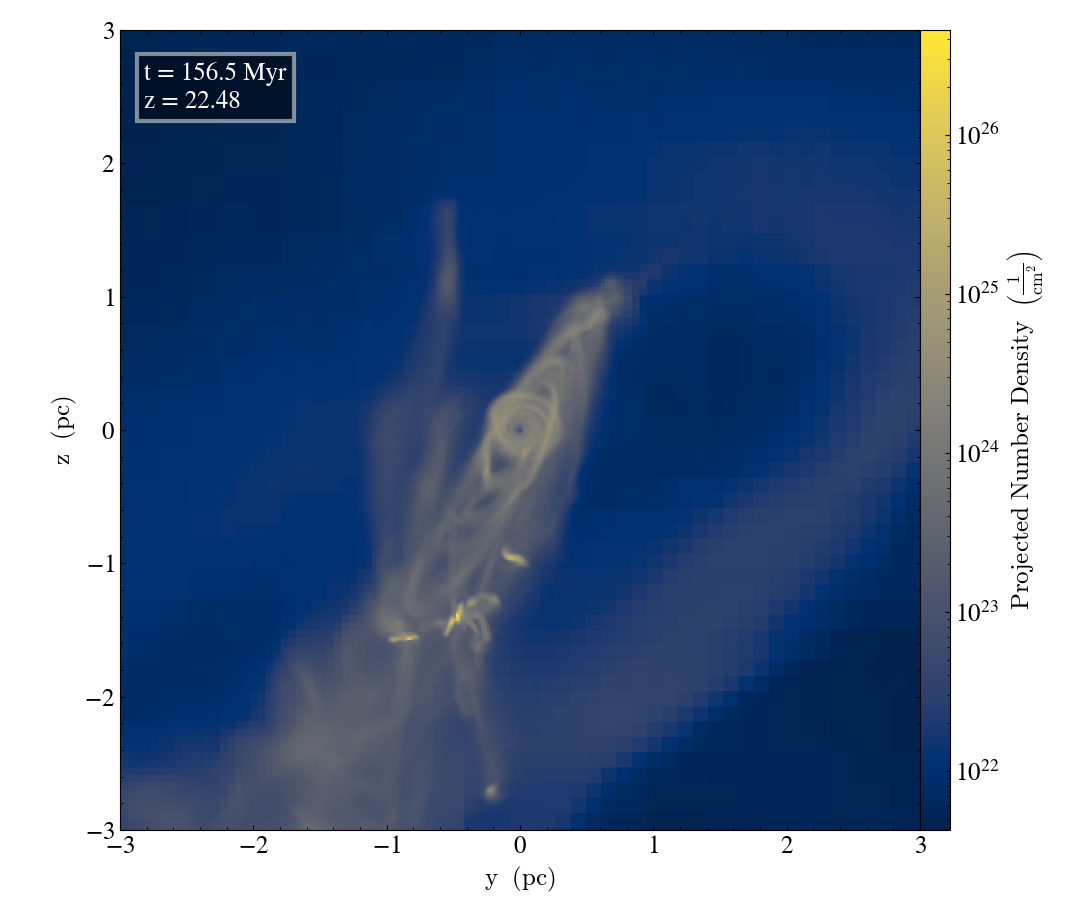

In [4]:
# plot projection of density
p = yt.ProjectionPlot(ds, 0, 'number_density', center=ss_pos, width=(6, 'pc'))
p.set_cmap('number_density', 'cividis')
#p.set_unit('number_density', 'cm**-3')
#p.set_zlim('number_density', 1e-2, 1e6)
p.annotate_timestamp(corner='upper_left', redshift=True, draw_inset_box=True)
p.show()


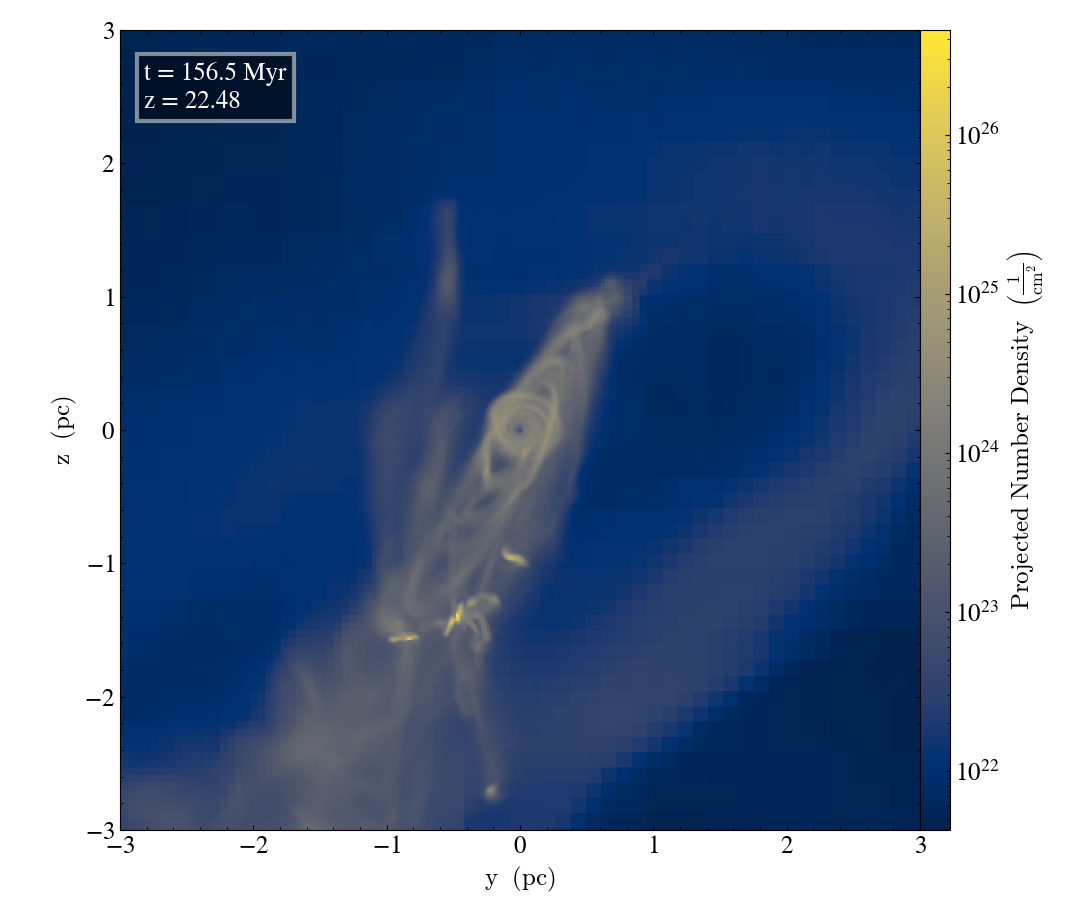

In [60]:
p.annotate_marker((0, 0), coord_system='plot', color='red', s=100)

In [94]:
# Make initial master clump (a disk containing the clump) - takes 30 seconds
L = [1, 0, 0]
clump_pos = ss_pos.to('pc') + [-2, -0.5, -1.5]*yt.units.pc
data_source = ds.disk(clump_pos, L, (1, "pc"), (1, "pc"))
master_clump = Clump(data_source, ("gas", "density"))

In [124]:
# Add information to the master clump
def _mass_weighted_jeans_mass(clump, units="Msun"):
    # Assuming this calculates a scalar value correctly
    jeans_mass = clump.quantities.weighted_average_quantity("jeans_mass", ("gas", "mass"))
    # Return as scalar if that's what's expected or adjust to return a tuple/list if needed
    return "Jeans mass: %s.", jeans_mass.to(units)

def _center_of_mass(clump, units="code_length", **kwargs):
    p = clump.quantities.center_of_mass(**kwargs)
    return "Center of mass: %s.", p.to(units)


add_clump_info("mass_weighted_jeans_mass", _mass_weighted_jeans_mass)
add_clump_info("position",  _center_of_mass)
master_clump.add_info_item("position")
master_clump.add_info_item("mass_weighted_jeans_mass")

In [125]:
master_clump.info

{'total_cells': ('Cells: %d.', 409039),
 'cell_mass': ('Mass: %e Msun.', unyt_quantity(6183.38359887, 'Msun')),
 'max_grid_level': ('Max grid level: %d.',
  unyt_quantity(14., '(dimensionless)')),
 'position': unyt_array([0.48801964, 0.49287402, 0.50822853], 'unitary'),
 'mass_weighted_jeans_mass': 'Position: (3.684474e+02) unitary.'}

In [6]:
#Add clump validators (refine clump properties)
master_clump.add_validator("min_cells", 20)
master_clump.add_validator("gravitationally_bound", use_particles=False)

def _minimum_gas_mass(clump, min_mass):
    return clump["gas", "mass"].sum() >= min_mass
add_validator("minimum_gas_mass", _minimum_gas_mass)
master_clump.add_validator("minimum_gas_mass", ds.quan(0.05, "Msun"))

In [107]:
# Find clumps - takes time, 2.10 minutes for 1B.RSb01-2/DD0445/DD0445
c_min = data_source["gas", "density"].min()*3
c_max = data_source["gas", "density"].max()
step = 1.5
find_clumps(master_clump, c_min, c_max, step)

yt : [INFO     ] 2024-03-27 11:31:54,480 Finding clumps: min: 9.091660e-23, max: 2.151189e-14, step: 1.500000


yt : [INFO     ] 2024-03-27 11:31:55,095 Linking node (507) contours.
yt : [INFO     ] 2024-03-27 11:31:56,560 Linked.
Updating joins ... : 100%|██████████| 507/507 [00:00<00:00, 8997.07it/s]
yt : [INFO     ] 2024-03-27 11:31:58,024 Finding clumps: min: 1.363749e-22, max: 2.151189e-14, step: 1.500000
yt : [INFO     ] 2024-03-27 11:31:58,025 Wiping out existing children clumps: 1.
yt : [INFO     ] 2024-03-27 11:31:58,217 Linking node (507) contours.
yt : [INFO     ] 2024-03-27 11:31:59,636 Linked.
Updating joins ... : 100%|██████████| 507/507 [00:00<00:00, 9106.53it/s]
yt : [INFO     ] 2024-03-27 11:32:00,924 Finding clumps: min: 2.045623e-22, max: 2.151189e-14, step: 1.500000
yt : [INFO     ] 2024-03-27 11:32:00,925 Wiping out existing children clumps: 1.
yt : [INFO     ] 2024-03-27 11:32:01,145 Linking node (507) contours.
yt : [INFO     ] 2024-03-27 11:32:02,601 Linked.
Updating joins ... : 100%|██████████| 507/507 [00:00<00:00, 8749.06it/s]
yt : [INFO     ] 2024-03-27 11:32:03,355 F

### Master Clump

In [117]:
# master clump mass and max level, not more can be known about the clump by default, need to add it myself
master_clump.info['position']

unyt_array([0.48801964, 0.49287402, 0.50822853], 'unitary')

In [109]:
# Get a list of just the leaf nodes.
leaf_clumps = master_clump.leaves

# Initialize variables to keep track of the most massive clump
most_massive_clump = None
max_leaf_mass = -1

# Find most massive leaf node
# Function to recursively traverse the clump hierarchy and analyze leaf clumps
def process_leaves(master_clump):
    global most_massive_clump, max_leaf_mass
    leaf_clumps = master_clump.leaves
    leaf_masses = []
    for clump in leaf_clumps:
        mass = clump.info["cell_mass"][1]
        #print("Clump leaf mass = {}".format(mass))
        leaf_masses.append(mass)
        if mass > max_leaf_mass:
            max_leaf_mass = mass
            most_massive_clump = clump
    print("Number of leaf clumps = {}".format(len(leaf_clumps)))
    print("Most massive leaf clump mass = {:.2f} (clump id {})".format(max_leaf_mass, most_massive_clump.clump_id))
    print("Least massive leaf clump mass = {:.5f} (clump id {})".format(min(leaf_masses), leaf_clumps[np.argmin(leaf_masses)].clump_id))
    return leaf_masses
        

In [110]:
leaf_masses = process_leaves(master_clump)

Number of leaf clumps = 60
Most massive leaf clump mass = 929.78 Msun (clump id 103)
Least massive leaf clump mass = 0.00023 Msun (clump id 14)


In [128]:
(most_massive_clump.info["position"] - ss_pos).to('pc')

unyt_array([-1.4141158 , -0.47112575, -1.3934967 ], 'pc')

In [45]:
# takes 1.11 minute to run
prj = yt.ProjectionPlot(ds, "y", ("gas", "number_density"), center=ss_pos, width=(6, "pc"))
#prj.annotate_clumps(leaf_clumps)
#prj.show()

yt : [INFO     ] 2024-03-27 10:20:26,197 Projection completed
yt : [INFO     ] 2024-03-27 10:20:26,202 xlim = 0.508175 0.508375
yt : [INFO     ] 2024-03-27 10:20:26,203 ylim = 0.487973 0.488173
yt : [INFO     ] 2024-03-27 10:20:26,207 xlim = 0.508175 0.508375
yt : [INFO     ] 2024-03-27 10:20:26,208 ylim = 0.487973 0.488173
yt : [INFO     ] 2024-03-27 10:20:26,210 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800


In [54]:
s = yt.SlicePlot(ds, "y", ("gas", "number_density"), center=ss_pos, width=(6, "pc"))

yt : [INFO     ] 2024-03-27 10:23:14,205 xlim = 0.508175 0.508375
yt : [INFO     ] 2024-03-27 10:23:14,207 ylim = 0.487973 0.488173
yt : [INFO     ] 2024-03-27 10:23:14,212 xlim = 0.508175 0.508375
yt : [INFO     ] 2024-03-27 10:23:14,213 ylim = 0.487973 0.488173
yt : [INFO     ] 2024-03-27 10:23:14,216 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800


In [28]:
com = most_massive_clump.quantities.center_of_mass()
com

unyt_array([4.51656999e+22, 4.56142393e+22, 4.70353644e+22], 'cm')

In [29]:
com.to('pc')

unyt_array([14637.20649078, 14782.56821732, 15243.123479  ], 'pc')

/home/sgordon/.local/lib/python3.10/site-packages/yt/visualization/plot_modifications.py:113: VisibleDeprecationWarning: `plot_args` is deprecated. You can now pass arbitrary keyword arguments instead of a dictionary.
Deprecated since yt 4.1.0
  self._callbacks.append(cls(*args, **kwargs))



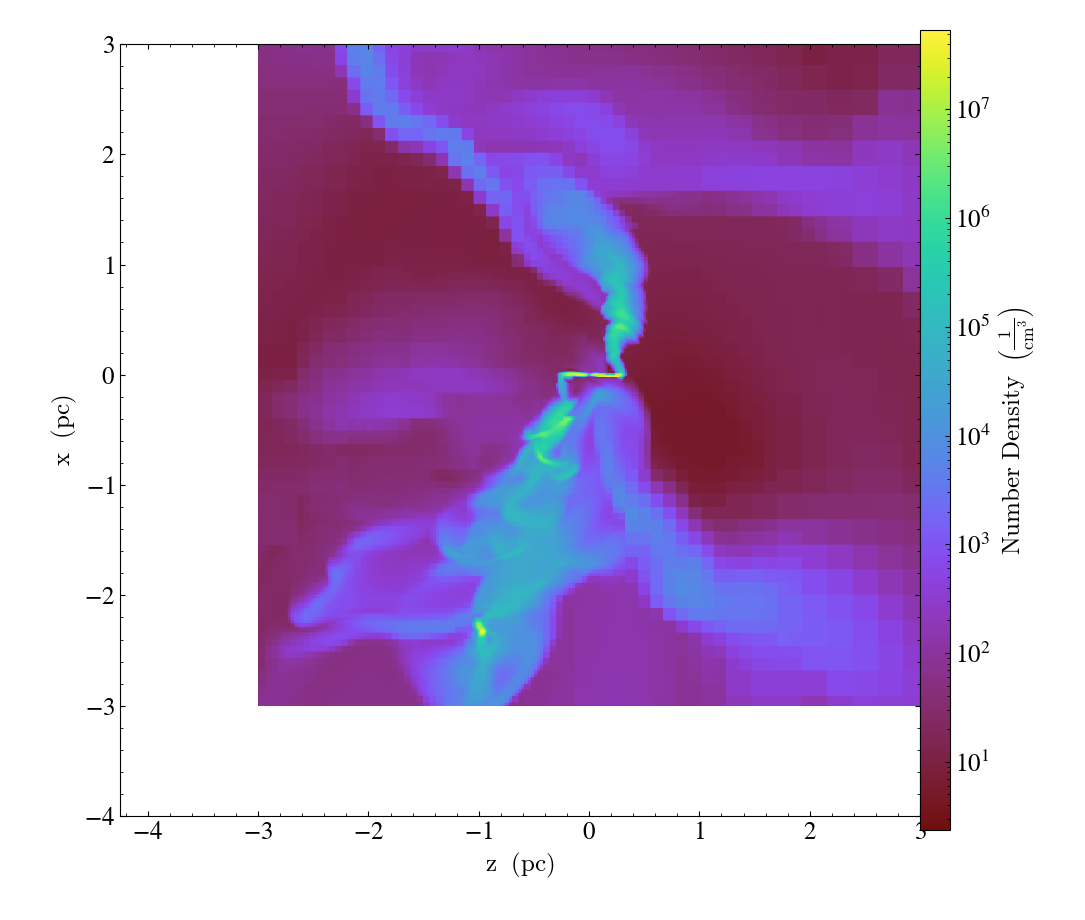

In [55]:
s.annotate_marker((-1, 1), coord_system='plot', plot_args={'color': 'white', 's': 500})
s.show()


In [137]:
my_clump = leaf_clumps[0]
print(my_clump["gas", "mass"]) # the mass of each cell in the clump
print(my_clump["gas", "density"]) 
print(my_clump["gas", "temperature"])

[2.38279808e+30 2.20311495e+30 1.95957482e+30 ... 1.95470610e+30
 1.97912295e+30 1.95945110e+30] g
[2.90089182e-20 2.68214004e-20 2.38564678e-20 ... 2.37971945e-20
 2.40944528e-20 2.38549616e-20] g/cm**3
[50.4672334  56.37485971 58.64919192 ... 39.53497857 33.74115713
 34.1731491 ] K


In [138]:
print(my_clump["gas", "h2_fraction"])

[0.01076823 0.01066531 0.01021996 ... 0.01125365 0.01144217 0.0114393 ] dimensionless
